In [215]:
# Program setup
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping

from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score, mean_absolute_error, precision_recall_fscore_support, recall_score, roc_curve
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor

df = pd.read_csv("data/Dry_Bean_Dataset.csv")
seed = 14
np.random.seed(seed)

In [216]:
# Inspect data
print(df.info())

print('\n', df.shape)
df.head()

# No 'object' type features
# Values will need scaling
# Target variable is called 'Class'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13611 entries, 0 to 13610
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13611 non-null  int64  
 1   Perimeter        13611 non-null  float64
 2   MajorAxisLength  13611 non-null  float64
 3   MinorAxisLength  13611 non-null  float64
 4   AspectRation     13611 non-null  float64
 5   Eccentricity     13611 non-null  float64
 6   ConvexArea       13611 non-null  int64  
 7   EquivDiameter    13611 non-null  float64
 8   Extent           13611 non-null  float64
 9   Solidity         13611 non-null  float64
 10  roundness        13611 non-null  float64
 11  Compactness      13611 non-null  float64
 12  ShapeFactor1     13611 non-null  float64
 13  ShapeFactor2     13611 non-null  float64
 14  ShapeFactor3     13611 non-null  float64
 15  ShapeFactor4     13611 non-null  float64
 16  Class            13611 non-null  object 
dtypes: float64(1

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
0,28395,610.291,208.178117,173.888747,1.197191,0.549812,28715,190.141097,0.763923,0.988856,0.958027,0.913358,0.007332,0.003147,0.834222,0.998724,SEKER
1,28734,638.018,200.524796,182.734419,1.097356,0.411785,29172,191.272751,0.783968,0.984986,0.887034,0.953861,0.006979,0.003564,0.909851,0.998430,SEKER
2,29380,624.110,212.826130,175.931143,1.209713,0.562727,29690,193.410904,0.778113,0.989559,0.947849,0.908774,0.007244,0.003048,0.825871,0.999066,SEKER
3,30008,645.884,210.557999,182.516516,1.153638,0.498616,30724,195.467062,0.782681,0.976696,0.903936,0.928329,0.007017,0.003215,0.861794,0.994199,SEKER
4,30140,620.134,201.847882,190.279279,1.060798,0.333680,30417,195.896503,0.773098,0.990893,0.984877,0.970516,0.006697,0.003665,0.941900,0.999166,SEKER


In [217]:
# Column names need tweaking
df = df.rename(columns={
    'MajorAxisLength': 'major_axis_length',
    'MinorAxisLength': 'minor_axis_length',
    'AspectRation': 'aspect_ratio', # This one is misspelt
    'ConvexArea': 'convex_area',
    'EquivDiameter': 'equivalent_diameter',
    'ShapeFactor1': 'shape_factor_1',
    'ShapeFactor2': 'shape_factor_2',
    'ShapeFactor3': 'shape_factor_3',
    'ShapeFactor4': 'shape_factor_4'
})

df.columns = df.columns.str.lower()
print(df.columns)

Index(['area', 'perimeter', 'major_axis_length', 'minor_axis_length',
       'aspect_ratio', 'eccentricity', 'convex_area', 'equivalent_diameter',
       'extent', 'solidity', 'roundness', 'compactness', 'shape_factor_1',
       'shape_factor_2', 'shape_factor_3', 'shape_factor_4', 'class'],
      dtype='object')


In [218]:
# Set numeric/categorical features & target
feature_names = list(df.columns)
target_name = feature_names.pop()

cat_feature_names = [col for col in feature_names if df[col].dtype == 'object']
print("The categorical features are: (There are no categorical features)\n", cat_feature_names)

num_feature_names = [col for col in feature_names if df[col].dtype == 'int64' or df[col].dtype == 'float64']
print("\nThe numeric features are: (All of the features are numeric)\n", num_feature_names)

print(f"\nThe target variable is:\n{target_name}")

The categorical features are: (There are no categorical features)
 []

The numeric features are: (All of the features are numeric)
 ['area', 'perimeter', 'major_axis_length', 'minor_axis_length', 'aspect_ratio', 'eccentricity', 'convex_area', 'equivalent_diameter', 'extent', 'solidity', 'roundness', 'compactness', 'shape_factor_1', 'shape_factor_2', 'shape_factor_3', 'shape_factor_4']

The target variable is:
class


In [219]:
# Check values for dtype 'object' columns; the only one is the target, 'Class', which I will change using .title()
unique_classes = df['class'].unique()
print(unique_classes)

for value in unique_classes:
    df['class'] = df['class'].replace(value, value.title())

# Check that classes have changed correctly
unique_classes = df['class'].unique()
print(unique_classes)

['SEKER' 'BARBUNYA' 'BOMBAY' 'CALI' 'HOROZ' 'SIRA' 'DERMASON']
['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']


In [220]:
# Check for missing values & duplicates. No missing values; 68 duplicates.
missing_values_count = df.isnull().sum()
print(missing_values_count)

duplicate_count = df.duplicated().sum()
print(f"\nThere are {duplicate_count} duplicates")

# Removing duplicates
print(f"Original DataFrame had {df.shape[0]} rows")
df = df.drop_duplicates()
print(f"After dropping duplicates, DataFrame has {df.shape[0]} rows")

area                   0
perimeter              0
major_axis_length      0
minor_axis_length      0
aspect_ratio           0
eccentricity           0
convex_area            0
equivalent_diameter    0
extent                 0
solidity               0
roundness              0
compactness            0
shape_factor_1         0
shape_factor_2         0
shape_factor_3         0
shape_factor_4         0
class                  0
dtype: int64

There are 68 duplicates
Original DataFrame had 13611 rows
After dropping duplicates, DataFrame has 13543 rows


In [221]:
# Summary statistics
target_stats = df[target_name].describe()
print(target_stats)

feature_num_stats = df[feature_names].describe()
feature_num_stats

# df[cat_feature_names].describe(include='object') # Not included, as there are not 'object' dtype features

count        13543
unique           7
top       Dermason
freq          3546
Name: class, dtype: object


,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
count,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000,13543.000000
mean,53048.460385,854.993406,319.895602,202.365321,1.581075,0.750315,53767.986709,253.034094,0.749829,0.987152,0.873671,0.800352,0.006561,0.001719,0.644341,0.995078
std,29392.438324,214.722684,85.809260,45.051632,0.245245,0.091858,29844.248525,59.307709,0.048939,0.004650,0.059393,0.061464,0.001130,0.000595,0.098653,0.004347
min,20420.000000,524.736000,183.601165,122.512653,1.024868,0.218951,20684.000000,161.243764,0.555315,0.919246,0.489618,0.640577,0.002778,0.000564,0.410339,0.947687
25%,36282.500000,703.230000,253.086806,175.886357,1.430662,0.715144,36673.000000,214.933277,0.718735,0.985678,0.833410,0.763228,0.005893,0.001158,0.582517,0.993720
50%,44580.000000,793.896000,296.404589,192.491117,1.549860,0.763997,45122.000000,238.245711,0.759903,0.988288,0.883490,0.801514,0.006643,0.001700,0.642424,0.996393
75%,61382.000000,977.146500,376.312489,217.245403,1.703916,0.809671,62360.000000,279.560351,0.786849,0.990019,0.917031,0.834470,0.007270,0.002173,0.696341,0.997891
max,254616.000000,1985.370000,738.860154,460.198497,2.430306,0.911423,263261.000000,569.374358,0.866195,0.994677,0.990685,0.987303,0.010451,0.003665,0.974767,0.999733


class
3    3545
6    2636
5    2026
4    1928
2    1630
0    1322
1     522
Name: count, dtype: int64


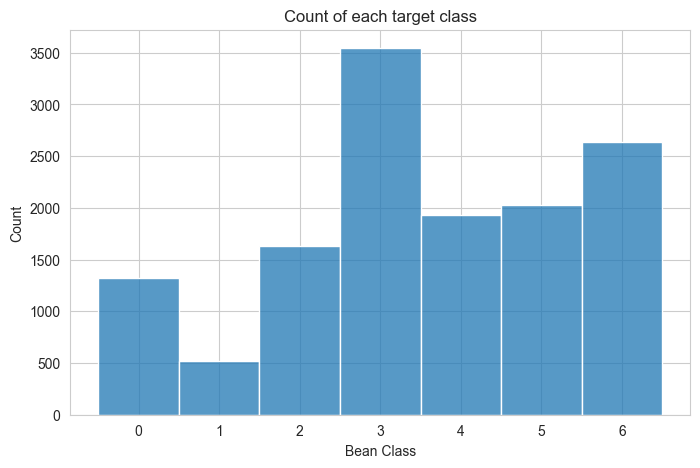

In [222]:
# Visualise distribution of target
sns.set_style('whitegrid')

plt.figure(figsize=(8,5))
plt.title('Count of each target class')
plt.xlabel('Bean Class')
plt.ylabel('Count')
plt.xticks(rotation=0, fontsize=10)
sns.histplot(y)

class_counts = (y.value_counts())
print(class_counts)

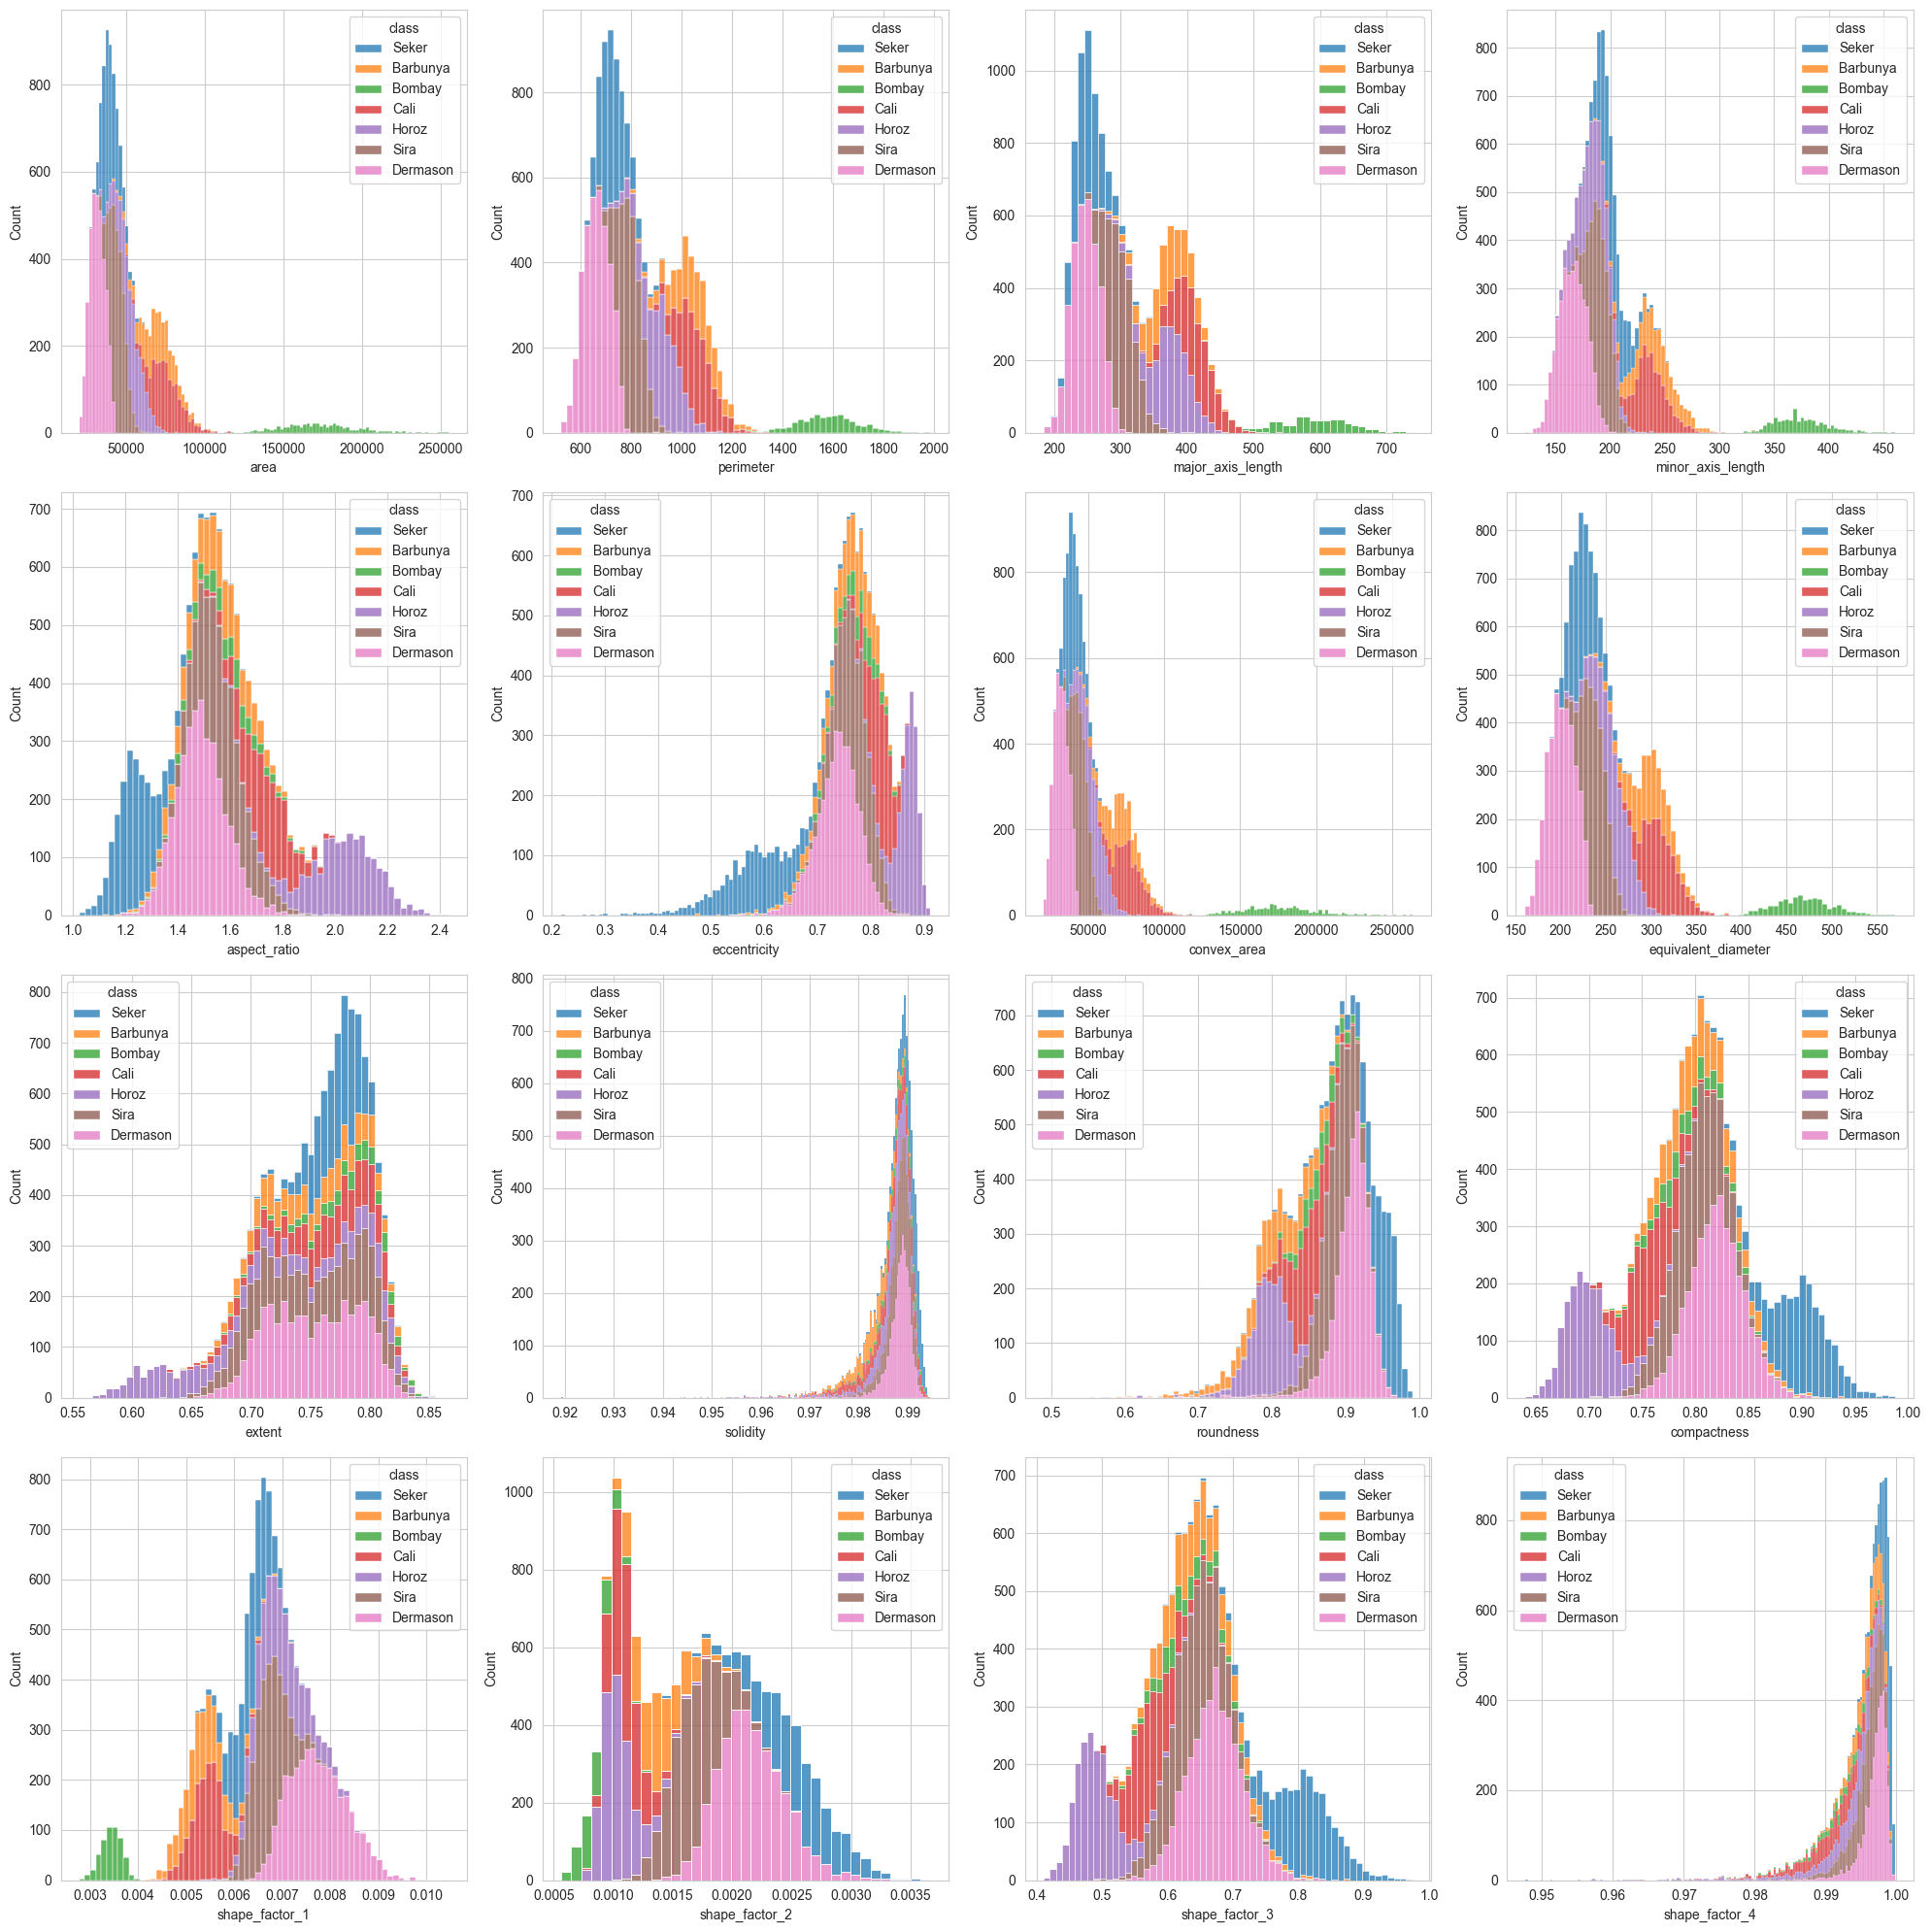

In [126]:
# Visualise distributions of features
fig, ax = plt.subplots(4,4, figsize=(20,20))

for variable, subplot in zip(feature_names, ax.flatten()):
    sns.histplot(data=df, x=variable, hue='class', ax=subplot, multiple='stack')
plt.tight_layout()

# Bombay is distinguishable on most features
# Seker distinguishable by eccentricity, compactness, & shape factor 3
# Horoz distinguishable by eccentricity, compactness, & shape factor 3

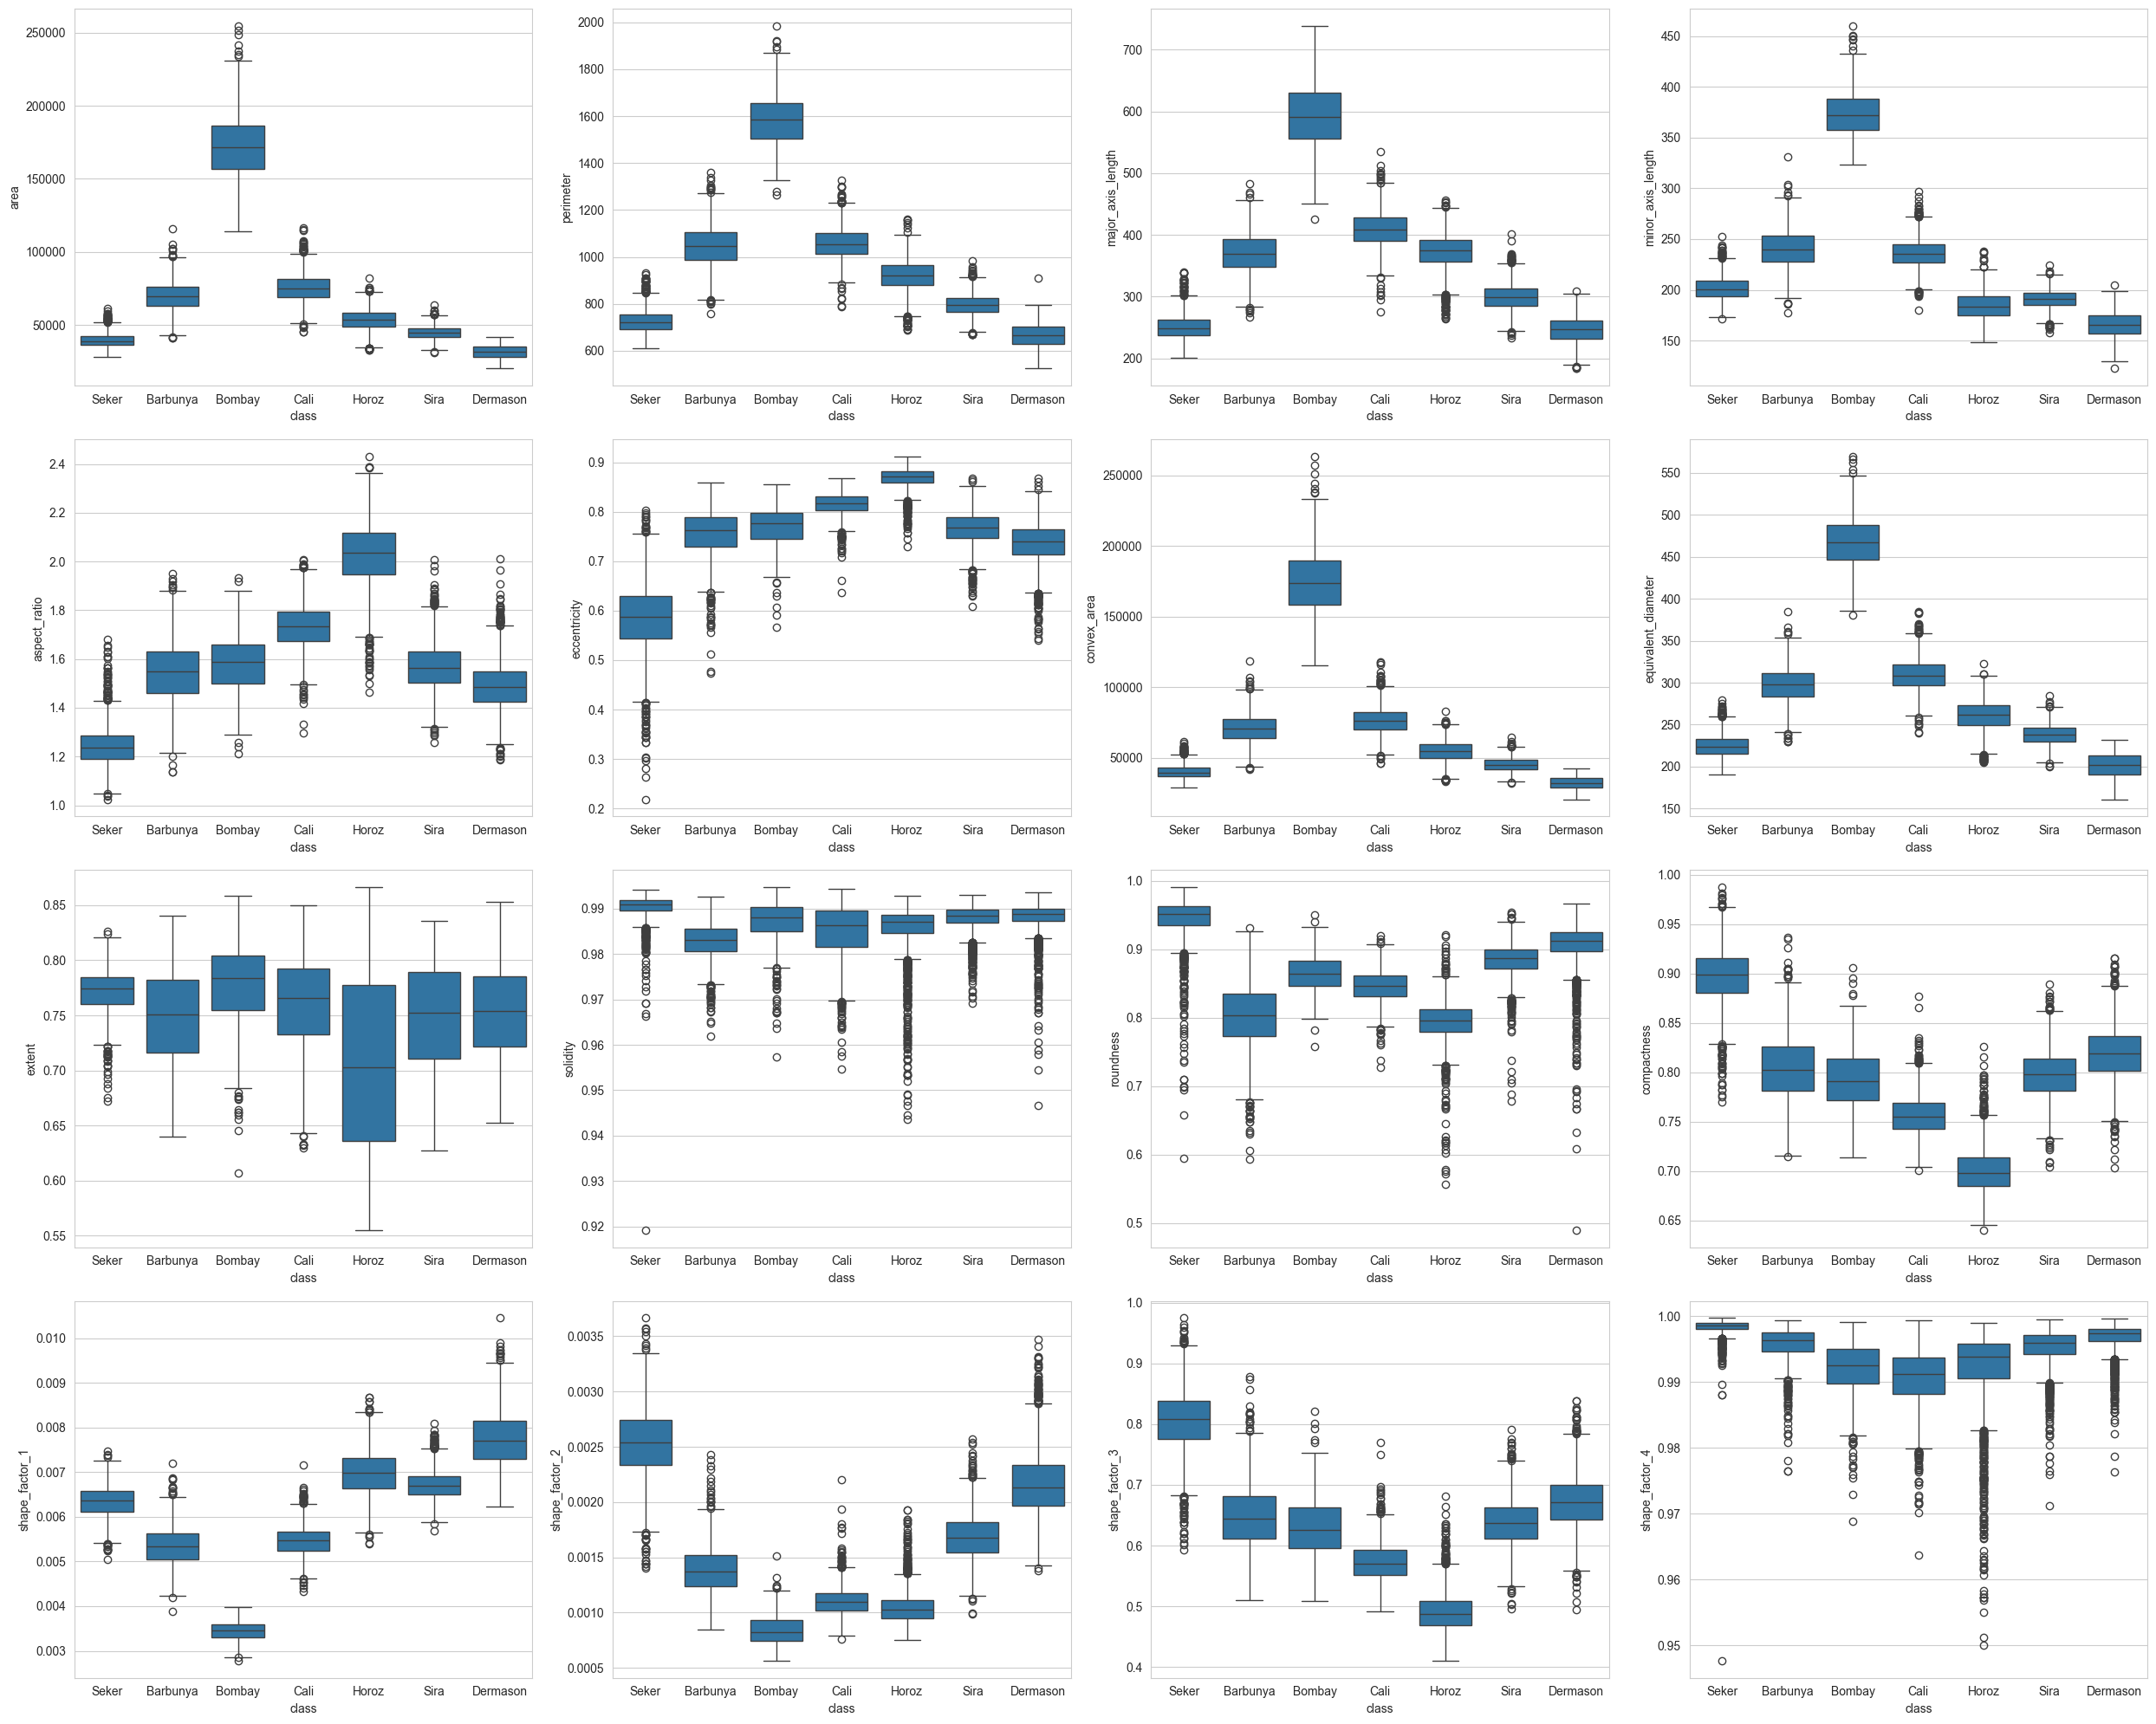

In [223]:
# Check for outliers
fig, ax = plt.subplots(4,4, figsize=(25,20))

for variable, subplot in zip(feature_names, ax.flatten()):
    sns.boxplot(x='class', y=variable, data=df, ax=subplot)
plt.tight_layout()

In [224]:
# Removing outliers
der_rou_filt = (df['roundness'] < 0.5) & (df['class'] == 'Dermason')
sek_sol_filt = (df['solidity'] < 0.93) & (df['class'] == 'Seker')
sek_sf4_filt = (df['shape_factor_4'] < 0.95) & (df['class'] == 'Seker')

df = df.loc[~der_rou_filt & ~sek_sol_filt & ~sek_sf4_filt]

# Reset class_counts
class_counts = df['class'].value_counts()

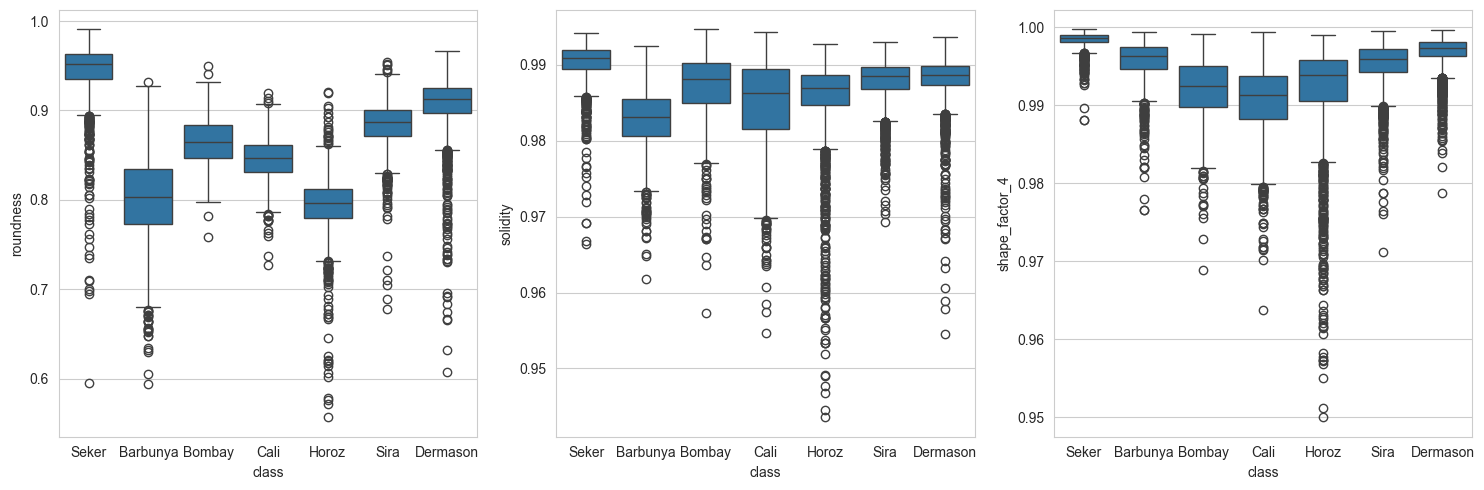

In [129]:
# View distributions with outliers have been removed
fig, ax = plt.subplots(1,3, figsize=(15,5))

for variable, subplot in zip(['roundness', 'solidity', 'shape_factor_4'], ax.flatten()):
        sns.boxplot(x='class', y=variable, data=df, ax=subplot)
plt.tight_layout()

In [229]:
# Label encoding target column
label_encoder = LabelEncoder()
df['class'] = label_encoder.fit_transform(df['class'])
df['class'] = df['class'].astype('category')

unique_labels = list(df['class'].unique())
print("The labels are: ", unique_labels)
print("The classes are: ", unique_classes)

label_dict = {}
for i, classes in enumerate(unique_classes):
    label_dict[unique_labels[i]] = classes

sorted_label_dict = {}
for i in range(len(unique_labels)):
    sorted_label_dict[i] = label_dict[i]
print("\nLabel Dictionary: ", sorted_label_dict)

# Compare the label counts to the class counts to check that the dictionary keys & values are assigned correctly
label_counts = df['class'].value_counts()
print(label_counts)
print(class_counts)

The labels are:  [5, 0, 1, 2, 4, 6, 3]
The classes are:  ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']

Label Dictionary:  {0: 'Barbunya', 1: 'Bombay', 2: 'Cali', 3: 'Dermason', 4: 'Horoz', 5: 'Seker', 6: 'Sira'}
class
3    3545
6    2636
5    2026
4    1860
2    1630
0    1322
1     522
Name: count, dtype: int64
class
Dermason    3545
Sira        2636
Seker       2026
Horoz       1860
Cali        1630
Barbunya    1322
Bombay       522
Name: count, dtype: int64


In [230]:
# Data preprocessing - splitting data
X = df.copy()
y = X.pop('class')

X_train, X_valid, y_train, y_valid = train_test_split(X, y, random_state=seed)

In [231]:
# Imputing not needed, as no missing values - ADD THESE
# Encoding not needed, as no categorical features
# Not making pipeline, as there is only the scaling step
scaler = StandardScaler()

X_train = pd.DataFrame(scaler.fit_transform(X_train), index=X_train.index)
X_train.columns = feature_names

X_valid = pd.DataFrame(scaler.transform(X_valid), index=X_valid.index)
X_valid.columns = feature_names

# Check that the training set has scaled correctly
X_train.head()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
10778,-0.859785,-1.111876,-1.127452,-0.956273,-0.737236,-0.548934,-0.858594,-1.095004,0.374526,-0.021890,0.782206,0.695674,1.298533,1.316964,0.674156,0.052989
5024,0.912288,1.027463,1.220013,0.867284,0.726044,0.788990,0.912111,1.109895,1.498998,-0.242081,-0.112044,-0.805152,-1.100038,-1.137062,-0.816578,-0.755248
1645,-0.310001,-0.399190,-0.547889,0.072118,-1.036457,-1.014643,-0.307749,-0.278158,0.164923,-0.360385,1.006546,1.083945,-0.311454,0.746548,1.087896,0.512295
745,-0.517636,-0.709519,-0.906487,-0.067083,-1.496483,-1.998512,-0.523669,-0.565382,0.574724,1.062571,1.517630,1.733781,-0.145510,1.595560,1.806184,0.787830
1899,-0.174568,-0.298805,-0.552090,0.490707,-1.497621,-2.001514,-0.184223,-0.101484,0.216226,1.210991,1.509250,1.729246,-0.774075,1.091902,1.801059,0.590462


In [232]:
# Check that the validation set has scaled correctly
X_valid.head()

,area,perimeter,major_axis_length,minor_axis_length,aspect_ratio,eccentricity,convex_area,equivalent_diameter,extent,solidity,roundness,compactness,shape_factor_1,shape_factor_2,shape_factor_3,shape_factor_4
3241,1.059346,1.273967,0.892754,1.537574,-0.493560,-0.236816,1.065196,1.253405,-0.092226,-0.709450,-0.734790,0.411092,-1.636278,-0.620920,0.378238,0.025865
11465,-0.766880,-0.934956,-0.921180,-0.904414,-0.372608,-0.099615,-0.765967,-0.942825,0.386479,-0.009201,0.382698,0.296169,1.176237,0.783774,0.260494,0.711359
12268,-0.660989,-0.823586,-0.791549,-0.706922,-0.423266,-0.155790,-0.663062,-0.777470,-0.202362,0.508694,0.769949,0.341345,0.822905,0.645211,0.306658,0.336419
5319,1.155447,1.333860,1.575175,0.957206,1.114522,1.000838,1.143663,1.345203,0.081468,0.583332,-0.589387,-1.125011,-1.176215,-1.338917,-1.111991,-0.823033
5687,-0.311564,-0.074009,0.317379,-0.890991,2.279848,1.458550,-0.312536,-0.280244,-0.093037,0.105951,-1.524681,-1.943960,1.190786,-1.126466,-1.832648,-0.645106


In [275]:
def eval_model_preds(y_preds):
    mae = mean_absolute_error(y_valid, y_preds)
    accuracy = accuracy_score(y_valid, y_preds)
    prfs_average = precision_recall_fscore_support(y_valid, y_preds, average='macro')
    prfs_individual = precision_recall_fscore_support(y_valid, y_preds, average=None)

    print(f"MAE: {mae}\nAccuracy: {accuracy}\nAverage Precision: {prfs_average[0]}\nAverage Recall: {prfs_average[1]}\nAverage F1-Score: {prfs_average[2]}")
    print(f"\nClass order: {unique_classes}")
    print(f"Support for each class: {prfs_individual[3]}")
    print(f"Per-class Precision: {prfs_individual[0]}\nPer-class Recall: {prfs_individual[1]}\nPer-class F1-score: {prfs_individual[2]}")

In [276]:
# Decision Tree model
tree_model = DecisionTreeRegressor(random_state=seed)

tree_model.fit(X_train, y_train)

tree_y_preds = tree_model.predict(X_valid)

tree_mae = mean_absolute_error(y_valid, tree_y_preds)

print(f"Decision Tree metrics:")
eval_model_preds(tree_y_preds)


Decision Tree metrics:
MAE: 0.27406969875959836
Accuracy: 0.8922031896042528
Average Precision: 0.9095238023109433
Average Recall: 0.9095959414674113
Average F1-Score: 0.9095484283032801

Class order: ['Seker' 'Barbunya' 'Bombay' 'Cali' 'Horoz' 'Sira' 'Dermason']
Support for each class: [315 131 413 867 477 520 663]
Per-class Precision: [0.90705128 1.         0.9060241  0.88228438 0.93710692 0.91778203
 0.81641791]
Per-class Recall: [0.8984127  1.         0.91041162 0.87312572 0.93710692 0.92307692
 0.82503771]
Per-class F1-score: [0.90271132 1.         0.90821256 0.87768116 0.93710692 0.92042186
 0.82070518]


In [237]:
tree_test_params = [{
    'max_leaf_nodes': [10, 25, 30, 40, 50, 75, 100, 150, 250, 500, 1000]
}]

tree_optimal_params = GridSearchCV(
    estimator = DecisionTreeRegressor(),
    param_grid = tree_test_params,
    cv=5,
    verbose=1,
)

tree_optimal_params.fit(X_train, y_train)
print(f"Optimal Decision Tree parameters: {tree_optimal_params.best_params_}")

Fitting 5 folds for each of 11 candidates, totalling 55 fits
Optimal Decision Tree parameters: {'max_leaf_nodes': 40}


In [249]:
def get_f1_score(model, X_t=X_train, X_v=X_valid, y_t=y_train, y_v=y_valid):
    model.fit(X_t, y_t)
    preds = model.predict(X_v)
    return f1_score(y_v, preds, average=None)

tree_1 = DecisionTreeRegressor(random_state=seed, max_leaf_nodes = 30)
tree_2 = DecisionTreeRegressor(random_state=seed, max_leaf_nodes = 40)
tree_3 = DecisionTreeRegressor(random_state=seed, max_leaf_nodes = 50)
tree_4 = DecisionTreeRegressor(random_state=seed, max_leaf_nodes = 100)

trees = [tree_1, tree_2, tree_3, tree_4]
for i in range(0, len(trees)):
    f1 = get_f1_score(trees[i])
    print(f"Tree {i+1} had F1 score of: {f1}")


ValueError: Classification metrics can't handle a mix of multiclass and continuous targets

In [140]:
# Random Forest model
forest_model = RandomForestRegressor(random_state=seed)

forest_model.fit(X_train, y_train)

forest_y_preds = forest_model.predict(X_valid)

forest_mae = mean_absolute_error(y_valid, forest_y_preds)
print(f"Random Forest MAE: {forest_mae}")

Random Forest MAE: 0.2575786071113723


In [141]:
# XGBoost model
xgb_model = XGBRegressor(random_state = seed)

xgb_model.fit(X_train, y_train)

xgb_y_preds = xgb_model.predict(X_valid)

xgb_mae = mean_absolute_error(y_valid, xgb_y_preds)
print(f"XGBoost MAE: {xgb_mae}")

XGBoost MAE: 0.32556138355191877


In [144]:
# SVM - Determine optimal parameters
svm_test_params = [{
    'C': [0.1, 0.5, 1, 10, 100],
    'gamma': ['scale', 1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf'],
    }]


svm_optimal_params = GridSearchCV(
    SVC(),
    svm_test_params,
    cv=5,
    scoring='accuracy',
    verbose=1,
)

svm_optimal_params.fit(X_train, y_train)
print("The optimal parameters are: ", svm_optimal_params.best_params_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


AttributeError: 'GridSearchCV' object has no attribute 'best_params'

In [146]:
# Define & fit SVM model; generate & evaluate predictions
svm_model = SVC(C=10, gamma='scale', kernel='rbf', decision_function_shape='ovr', random_state=seed)

svm_model.fit(X_train, y_train)

svm_preds = svm_model.predict(X_valid)

svm_mae = mean_absolute_error(y_valid, svm_preds)
print(f"SVM MAE: {svm_mae}")

SVM MAE: 0.16132823978842198
